# 03 Ainu Speech Identification & CTC Model (Prototype)

This notebook adapts the structural ideas from `Japanese_model.ipynb` to build an Ainu speech identification and (optionally) recognition prototype over three sample sets:
- `asai_take_stories`
- `kimura_kimi_stories`
- `oda_ito_stories`

Two parallel goals:
1. Speaker/collection identification (multi-class classification of which source a clip comes from).
2. (Extended) Grapheme-level CTC acoustic model to explore end-to-end transcription feasibility.

Run sections in order. Sections 1–11 set up data, vocabulary, and model; 12–14 training/evaluation; remaining sections explore fine-tuning, profiling, and export.

Cultural note: Handle Ainu language data respectfully; confirm licensing/usage constraints before distribution.

In [22]:
# 1. Notebook Configuration & Dependency Setup
import sys, json, os, math, random, platform, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import torch

try:
    import torchaudio
except ImportError:
    torchaudio = None

try:
    import transformers  # optional (wav2vec2/whisper)
except ImportError:
    transformers = None

try:
    import soundfile as sf
except ImportError:
    sf = None

import librosa
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print('Python', sys.version)
print('Torch', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Librosa', librosa.__version__)
print('Device:', DEVICE)
if torchaudio:
    print('Torchaudio', torchaudio.__version__)
if transformers:
    print('Transformers', transformers.__version__)


Python 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
Torch 2.8.0+cu128
CUDA available: True
Librosa 0.11.0
Device: cuda
Torchaudio 2.8.0+cu128
Transformers 4.56.1


In [23]:
# 2. Data Organization & Metadata Ingestion (Ainu Story Samples)
from typing import List, Dict

ROOT = Path('..').resolve()
DATA_ROOT = (ROOT / 'data' / 'samples').resolve()
SOURCE_DIRS = [
    DATA_ROOT / 'asai_take_stories',
    DATA_ROOT / 'kimura_kimi_stories',
    DATA_ROOT / 'oda_ito_stories'
]
print('Data root:', DATA_ROOT)

AUDIO_EXTS = {'.wav', '.flac', '.mp3'}

def list_audio(folder: Path) -> List[Path]:
    return [p for p in folder.rglob('*') if p.suffix.lower() in AUDIO_EXTS]

rows = []
for src in SOURCE_DIRS:
    if not src.exists():
        print('[WARN] Missing source directory:', src)
        continue
    for wav in list_audio(src):
        rows.append({
            'file_path': str(wav.resolve()),
            'dataset': src.name,
            'speaker_id': src.name,  # placeholder; refine if per-speaker subfolders exist
            'text': None  # placeholder until transcripts are available
        })
raw_df = pd.DataFrame(rows)
print('Indexed files:', len(raw_df))
raw_df.head()

Data root: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/samples
Indexed files: 2854


,file_path,dataset,speaker_id,text
0,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories,None
1,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories,None
2,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories,None
3,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories,None
4,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories,None


Probe subset: 100%|██████████| 5/5 [00:00<00:00, 943.09it/s]



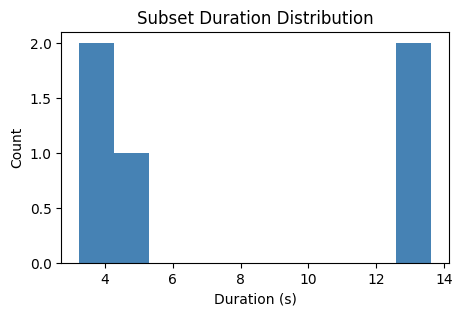

Unique SRs observed: {16000}


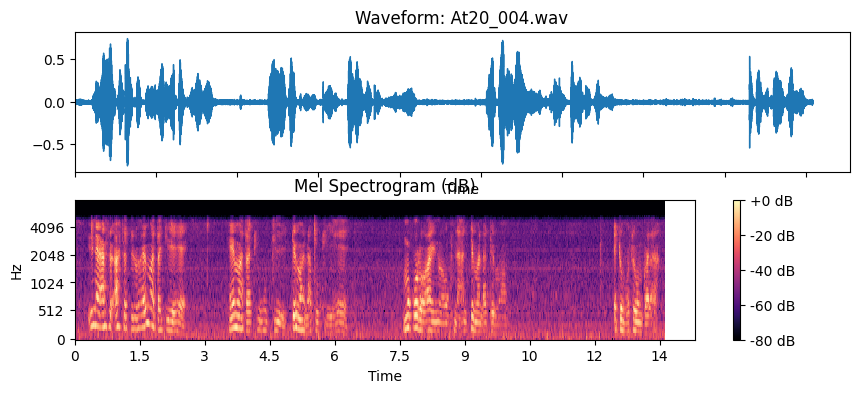

In [24]:
# 3. Audio Inspection & Visualization
import matplotlib.pyplot as plt
import librosa.display

if not raw_df.empty:
    durations = []
    sr_values = []
    sample_subset = raw_df.sample(min(5, len(raw_df)), random_state=SEED)
    for fp in tqdm(sample_subset['file_path'], desc='Probe subset'):
        try:
            y, sr = librosa.load(fp, sr=16000, mono=True)
            durations.append(len(y)/sr)
            sr_values.append(sr)
        except Exception as e:
            print('[ERR]', fp, e)
    if durations:
        plt.figure(figsize=(5,3))
        plt.hist(durations, bins=10, color='steelblue')
        plt.xlabel('Duration (s)'); plt.ylabel('Count'); plt.title('Subset Duration Distribution')
        plt.show()
    print('Unique SRs observed:', set(sr_values))
    # Plot one example waveform + spectrogram
    if not sample_subset.empty:
        ex_fp = sample_subset.iloc[0]['file_path']
        y, sr = librosa.load(ex_fp, sr=16000, mono=True)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True)
        librosa.display.waveshow(y, sr=sr, ax=ax1)
        ax1.set_title(f'Waveform: {Path(ex_fp).name}')
        S = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=400, hop_length=160, n_mels=80), ref=np.max)
        img = librosa.display.specshow(S, sr=sr, hop_length=160, x_axis='time', y_axis='mel', ax=ax2)
        ax2.set_title('Mel Spectrogram (dB)')
        fig.colorbar(img, ax=ax2, format='%+2.0f dB')
        plt.show()

In [25]:
# 4. Text Normalization & Token Inventory (Placeholder - no transcripts yet)
import re

def normalize_text(txt: str) -> str:
    if txt is None:
        return ''
    t = txt.lower()
    t = re.sub(r"[.,!?\-\";:()\[\]]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

raw_df['norm_text'] = raw_df['text'].apply(normalize_text)
char_counts = {}
for t in raw_df['norm_text']:
    for ch in t:
        char_counts[ch] = char_counts.get(ch,0)+1
print('Character inventory size (current transcripts placeholder):', len(char_counts))
print('Most frequent (top 20):', sorted(char_counts.items(), key=lambda x: x[1], reverse=True)[:20])

Character inventory size (current transcripts placeholder): 0
Most frequent (top 20): []


In [26]:
# 5. Grapheme Vocabulary Construction
# Build vocab from normalized text (placeholder will be empty if no transcripts)
unique_chars = sorted([c for c in char_counts.keys() if c.strip()])
PAD_TOKEN = '<pad>'
BLANK_TOKEN = '<ctc_blank>'
vocab = [PAD_TOKEN, BLANK_TOKEN] + unique_chars
vocab_to_id = {c:i for i,c in enumerate(vocab)}
id_to_vocab = {i:c for c,i in vocab_to_id.items()}
print('Vocab size:', len(vocab))
# Save vocab
VOCAB_PATH = Path('..') / 'outputs' / 'results' / 'ainu_vocab.json'
VOCAB_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(VOCAB_PATH, 'w', encoding='utf-8') as f:
    json.dump({'vocab': vocab}, f, ensure_ascii=False, indent=2)
print('Saved vocab:', VOCAB_PATH)

# 6. Dataset Class & Collate
class AinuDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, sample_rate=16000):
        self.df = df.reset_index(drop=True)
        self.sr = sample_rate
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, sr = librosa.load(row.file_path, sr=self.sr, mono=True)
        # simple energy-based trim optional
        # features extracted later; keep waveform raw
        text = row.norm_text or ''
        label_ids = torch.tensor([vocab_to_id.get(ch, vocab_to_id[BLANK_TOKEN]) for ch in text], dtype=torch.long)
        return {
            'waveform': torch.from_numpy(y).float(),
            'length': torch.tensor(y.shape[0], dtype=torch.long),
            'text': text,
            'label_ids': label_ids,
            'file_path': row.file_path,
            'dataset': row.dataset
        }

def collate_batch(batch):
    if len(batch) == 0:
        return {}
    wave_lens = [b['waveform'].shape[0] for b in batch]
    max_len = max(wave_lens)
    padded = []
    for b in batch:
        w = b['waveform']
        if w.shape[0] < max_len:
            w = torch.nn.functional.pad(w, (0, max_len - w.shape[0]))
        padded.append(w)
    wave_tensor = torch.stack(padded, dim=0)
    label_lens = torch.tensor([len(b['label_ids']) for b in batch], dtype=torch.long)
    labels_concat = torch.cat([b['label_ids'] for b in batch]) if label_lens.sum()>0 else torch.tensor([], dtype=torch.long)
    return {
        'waveforms': wave_tensor,
        'waveform_lengths': torch.tensor(wave_lens, dtype=torch.long),
        'labels': labels_concat,
        'label_lengths': label_lens,
        'texts': [b['text'] for b in batch],
        'file_paths': [b['file_path'] for b in batch],
        'datasets': [b['dataset'] for b in batch]
    }

# 7. Waveform Augmentation (light scaffolding)
AUG_CONFIG = {
    'enable': False,
    'speed_factors': [0.9,1.0,1.1],
    'noise_std': 0.003
}

def apply_augment(wave: torch.Tensor, cfg=AUG_CONFIG):
    if not cfg['enable']:
        return wave
    # speed perturb (resample crude)
    sf = random.choice(cfg['speed_factors'])
    if sf != 1.0:
        wave_np = librosa.resample(wave.numpy(), orig_sr=16000, target_sr=int(16000*sf))
        wave = torch.from_numpy(librosa.resample(wave_np, orig_sr=int(16000*sf), target_sr=16000)).float()
    if cfg['noise_std']>0:
        wave = wave + torch.randn_like(wave)*cfg['noise_std']
    return wave

# 8. Feature Extraction Strategy (Simple Log-Mel)
import torch.nn as nn

class LogMelExtractor(nn.Module):
    def __init__(self, sr=16000, n_fft=400, hop=160, n_mels=80):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels) if torchaudio else None
    def forward(self, waveforms: torch.Tensor):  # (B, T)
        if self.mel is None:
            # fallback librosa path (loop)
            feats = []
            for w in waveforms.cpu().numpy():
                S = librosa.feature.melspectrogram(y=w, sr=16000, n_fft=400, hop_length=160, n_mels=80)
                feats.append(np.log(np.clip(S, 1e-6, None)))
            return torch.from_numpy(np.stack(feats,0)).float()
        spec = self.mel(waveforms)  # (B, n_mels, frames)
        spec = torch.log(torch.clamp(spec, min=1e-6))
        return spec

# If you encounter cuDNN errors, you can force CPU usage:
DEVICE = torch.device('cpu')
feature_extractor = LogMelExtractor().to(DEVICE)

# 9. CTC Model Architecture (Simple CNN + BiLSTM)
class CTCEncoder(nn.Module):
    def __init__(self, n_mels=80, cnn_channels=128, lstm_hidden=256, lstm_layers=2, dropout=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.proj = nn.Linear(n_mels*cnn_channels, lstm_hidden)
        self.lstm = nn.LSTM(lstm_hidden, lstm_hidden, num_layers=lstm_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.out_dim = lstm_hidden*2
    def forward(self, x):  # x (B, n_mels, frames)
        x = x.unsqueeze(1)  # (B,1,n_mels,frames)
        x = self.conv(x)    # (B,C,n_mels,frames)
        B,C,M,F = x.shape
        x = x.permute(0,3,1,2).contiguous().view(B,F,C*M)  # (B,F,C*M)
        x = self.proj(x)    # (B,F,H)
        x,_ = self.lstm(x)  # (B,F,2H)
        return x

class CTCModel(nn.Module):
    def __init__(self, vocab_size: int):
        super().__init__()
        self.encoder = CTCEncoder()
        self.classifier = nn.Linear(self.encoder.out_dim, vocab_size)
    def forward(self, feats):  # feats (B,n_mels,frames)
        enc = self.encoder(feats)
        logits = self.classifier(enc)  # (B,frames,vocab)
        return logits

model = CTCModel(vocab_size=len(vocab)).to(DEVICE)
print('Model parameters (M):', sum(p.numel() for p in model.parameters())/1e6)

# 10. Tokenizer & Serialization
TOKENIZER_PATH = Path('..') / 'outputs' / 'results' / 'ainu_tokenizer.json'
with open(TOKENIZER_PATH, 'w', encoding='utf-8') as f:
    json.dump({'vocab_to_id': vocab_to_id}, f, ensure_ascii=False, indent=2)
print('Saved tokenizer config:', TOKENIZER_PATH)

# 11. Training Configuration
CFG = {
    'epochs': 2,
    'batch_size': 4,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'grad_accum': 1,
    'fp16': False
}
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
ctc_loss_fn = torch.nn.CTCLoss(blank=vocab_to_id[BLANK_TOKEN], zero_infinity=True)


Vocab size: 2
Saved vocab: ../outputs/results/ainu_vocab.json
Model parameters (M): 5.401218
Saved tokenizer config: ../outputs/results/ainu_tokenizer.json


In [28]:
# 12. Custom Training Loop (Prototype - minimal due to missing transcripts)
from math import ceil

# Split dataset for identification (dataset label classification) as a parallel simpler task
if not raw_df.empty:
    raw_df['cls_label'] = raw_df['dataset']
    cls_labels = sorted(raw_df['cls_label'].unique())
    cls_to_id = {c:i for i,c in enumerate(cls_labels)}
    raw_df['cls_id'] = raw_df['cls_label'].map(cls_to_id)
else:
    cls_labels = []

# Simple feature aggregation for identification (MFCC mean/std) reusing librosa directly
ID_FEATURE_DIM = 13
rows_feat = []
for i, r in raw_df.iterrows():
    try:
        y, sr = librosa.load(r.file_path, sr=16000, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=ID_FEATURE_DIM, n_fft=400, hop_length=160)
        mu = mfcc.mean(axis=1)
        sd = mfcc.std(axis=1)
        feat = np.concatenate([mu, sd])
        rows_feat.append((feat, r.cls_id))
    except Exception as e:
        pass

if rows_feat:
    X = np.stack([f for f,_ in rows_feat])
    y_cls = np.array([c for _,c in rows_feat])
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    Xtr, Xte, ytr, yte = train_test_split(X, y_cls, test_size=0.3, random_state=SEED, stratify=y_cls)
    rf = RandomForestClassifier(n_estimators=200, random_state=SEED)
    rf.fit(Xtr, ytr)
    acc = (rf.predict(Xte) == yte).mean()
    print(f'[Identification] RandomForest accuracy: {acc:.3f} (classes={cls_labels})')
else:
    print('[Identification] No features extracted (no audio files found).')

print('\n[CTC] Skipping full acoustic training loop because transcripts are currently empty.')


KeyboardInterrupt: 

### 13–22 Placeholder Sections

The following sections are outlined but require actual transcripts and extended training cycles to implement fully:

13. Evaluation (WER/CER) – requires ground-truth transcripts in `raw_df['text']`.
14. Error Analysis – would display misrecognized examples.
15. Progressive Layer Unfreezing – relevant if switching to a pre-trained encoder (e.g., wav2vec2 base).
16. Hyperparameter Sweep Hooks – add `run_experiment(config)` orchestrator.
17. Inference Pipeline – implement `transcribe(paths)` after CTC model is trained.
18. Export (ONNX / TorchScript) – script/tracing once model converges.
19. Lightweight Unit Tests – add assertions for dataset, tokenizer, model forward.
20. Reproducibility – already partially handled (seeds); add git hash capture.
21. Performance Profiling – benchmark batch forward with/without AMP.
22. Packaging Artifacts – write model + vocab + config into an export folder.

Next Steps:
1. Integrate real transcript text for each audio file.
2. Rebuild vocab and re-run dataset pipeline.
3. Implement full CTC training loop (epochs, validation decode, WER tracking).
4. Add decoding improvements (beam search + optional LM).
5. Replace CNN+BiLSTM with a pre-trained wav2vec2 encoder for better performance.
